In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# 讀取CSV資料
file_path = 'mangodata/MangoIrwin.csv'
data = pd.read_csv(file_path)

# 將資料轉換為DataFrame
df = pd.DataFrame(data)
df

ModuleNotFoundError: No module named 'seaborn'

In [6]:
# 篩選出 "台北一" 市場的所有資料並使用 .loc 進行操作
df_taipei1 = df.loc[df['市場'] == '台北一'].copy()
df_taipei1

,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
1049,2014/4/1,台北一,芒果 愛文,322.2,122.8,66.7,151.5,519
1050,2014/4/2,台北一,芒果 愛文,263.5,108.1,54.8,128.5,385
1051,2014/4/3,台北一,芒果 愛文,322.9,132.7,86.5,161.5,244
1052,2014/4/4,台北一,芒果 愛文,276.1,105.2,67.7,131.9,349
1053,2014/4/8,台北一,芒果 愛文,207.4,102.7,69.3,116.9,813
...,...,...,...,...,...,...,...,...
2993,2023/9/26,台北一,芒果 愛文,168.0,85.6,44.1,93.8,"1,668"
2994,2023/9/27,台北一,芒果 愛文,207.6,88.4,36.4,101.9,"1,497"
2995,2023/9/28,台北一,芒果 愛文,183.6,87.6,41.4,97.5,"1,632"
2996,2023/9/29,台北一,芒果 愛文,195.2,74.1,26.4,88.8,"1,439"


In [7]:
# 將'日期'轉換為datetime格式
df_taipei1['日期'] = pd.to_datetime(df_taipei1['日期'])
# 從'日期'中提取年, 月, 日
df_taipei1['年份']= df_taipei1['日期'].dt.year
df_taipei1['月份']= df_taipei1['日期'].dt.month
df_taipei1['日']= df_taipei1['日期'].dt.day

# 移除交易量中的逗號，並轉換為數值型態
df_taipei1['交易量(公斤)'] = df_taipei1['交易量(公斤)'].str.replace(',', '').astype(float)

# 檢查日期欄位是否有重複值，並移除重複日期
df_taipei1 = df_taipei1.drop_duplicates(subset=['日期'])

# 按年份分組並收集日期資料到字典中
year_datas = {}
for year, group in df_taipei1.groupby('年份'):
    year_datas[year] = {
         # 將datetime轉換為字串列表
        '日期': group['日期'].dt.strftime('%Y/%m/%d').tolist(),
        '市場': group['市場'].tolist(),
        '產品': group['產品'].tolist(),
        '上價': group['上價'].tolist(),
        '中價': group['中價'].tolist(),
        '下價': group['下價'].tolist(),
        '平均價(元/公斤)': group['平均價(元/公斤)'].tolist(),
        '交易量(公斤)': group['交易量(公斤)'].tolist()
         
    }

In [8]:
# 創建空的DataFrame來存儲結果
df = pd.DataFrame()

# 迴圈處理每個年份的資料
for year, year_data in year_datas.items():
    # 將資料轉換為DataFrame並將日期轉換為datetime格式
    df_year_data = pd.DataFrame(year_data)
    df_year_data['日期'] = pd.to_datetime(df_year_data['日期'])
    
    # 生成完整的日期範圍（這裡假設所有資料都是4月到9月的）
    start_date = f'{year}-04-01'
    end_date = f'{year}-09-30'
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 將日期設置為索引
    df_year_data.set_index('日期', inplace=True)

     # 重新索引以包含所有日期
    df_year_data = df_year_data.reindex(date_range)

    # 或者使用平均值插補
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].interpolate(method='linear')
    df_year_data['上價'] = df_year_data['上價'].interpolate(method='linear')
    df_year_data['中價'] = df_year_data['中價'].interpolate(method='linear')
    df_year_data['下價'] = df_year_data['下價'].interpolate(method='linear')
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].interpolate(method='linear')

    # 使用前向填充和後向填充來處理剩餘的缺失值
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].ffill().bfill()
    df_year_data['上價'] = df_year_data['上價'].ffill().bfill()
    df_year_data['中價'] = df_year_data['中價'].ffill().bfill()
    df_year_data['下價'] = df_year_data['下價'].ffill().bfill()
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].ffill().bfill()

    # 將交易量(公斤)轉換為整數
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].astype(int)


    # 填充市場和產品欄位
    market_value = year_data['市場'][0] if '市場' in year_data else '未知市場'
    product_value = year_data['產品'][0] if '產品' in year_data else '未知產品'
    df_year_data['市場'] = market_value
    df_year_data['產品'] = product_value

    # 重置索引並添加年份列
    df_year_data.reset_index(inplace=True)
    
    # 將索引顯示到日期欄位
    df_year_data.rename(columns={'index': '日期'}, inplace=True)
    
    # 將處理好的數據添加到結果DataFrame中
    df = pd.concat([df, df_year_data], ignore_index=True)


# 檢查缺失值
# missing_values = df.isnull().sum()
# print(missing_values)


# 輸出前50筆結果
# print(df.head)
df.head()

# 輸出後50筆結果
# df.tail(50)

,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,2014-04-01,台北一,芒果 愛文,322.200,122.800,66.7,151.50,519
1,2014-04-02,台北一,芒果 愛文,263.500,108.100,54.8,128.50,385
2,2014-04-03,台北一,芒果 愛文,322.900,132.700,86.5,161.50,244
3,2014-04-04,台北一,芒果 愛文,276.100,105.200,67.7,131.90,349
4,2014-04-05,台北一,芒果 愛文,258.925,104.575,68.1,128.15,465


In [9]:
# 查看資料狀態
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   日期         1830 non-null   datetime64[ns]
 1   市場         1830 non-null   object        
 2   產品         1830 non-null   object        
 3   上價         1830 non-null   float64       
 4   中價         1830 non-null   float64       
 5   下價         1830 non-null   float64       
 6   平均價(元/公斤)  1830 non-null   float64       
 7   交易量(公斤)    1830 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 114.5+ KB


In [10]:
# 查看資料有無重複值
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1825    False
1826    False
1827    False
1828    False
1829    False
Length: 1830, dtype: bool

In [11]:
# 提取日期的各個部分作為特徵
df['年份'] = df['日期'].dt.year
df['月份'] = df['日期'].dt.month
df['日'] = df['日期'].dt.day

# 調整欄位順序
df = df[['日期', '年份', '月份', '日', '上價', '中價', '下價', '平均價(元/公斤)', '交易量(公斤)']]

# 查看資料分布狀況
df.drop(columns=['日期']).describe()

,年份,月份,日,上價,中價,下價,平均價(元/公斤),交易量(公斤)
count,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000,1830.000000
mean,2018.500000,6.502732,15.754098,138.273197,70.748251,40.582541,78.218197,19658.169945
std,2.873066,1.701877,8.809364,74.639188,38.211747,26.386731,41.329875,18235.915574
min,2014.000000,4.000000,1.000000,39.400000,23.600000,13.400000,25.900000,6.000000
25%,2016.000000,5.000000,8.000000,84.000000,45.300000,27.000000,49.700000,4099.500000
50%,2018.500000,7.000000,16.000000,124.200000,64.175000,35.400000,71.150000,15003.500000
75%,2021.000000,8.000000,23.000000,168.425000,85.675000,48.000000,95.100000,29999.000000
max,2023.000000,9.000000,31.000000,680.000000,650.000000,650.000000,650.000000,102946.000000


In [12]:
# 查看資料是否有Null值
missing_values = df.isnull().sum()
print(missing_values)

日期           0
年份           0
月份           0
日            0
上價           0
中價           0
下價           0
平均價(元/公斤)    0
交易量(公斤)      0
dtype: int64


In [13]:
df

,日期,年份,月份,日,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,2014-04-01,2014,4,1,322.200,122.800,66.7,151.50,519
1,2014-04-02,2014,4,2,263.500,108.100,54.8,128.50,385
2,2014-04-03,2014,4,3,322.900,132.700,86.5,161.50,244
3,2014-04-04,2014,4,4,276.100,105.200,67.7,131.90,349
4,2014-04-05,2014,4,5,258.925,104.575,68.1,128.15,465
...,...,...,...,...,...,...,...,...,...
1825,2023-09-26,2023,9,26,168.000,85.600,44.1,93.80,1668
1826,2023-09-27,2023,9,27,207.600,88.400,36.4,101.90,1497
1827,2023-09-28,2023,9,28,183.600,87.600,41.4,97.50,1632
1828,2023-09-29,2023,9,29,195.200,74.100,26.4,88.80,1439


In [14]:
price = df['平均價(元/公斤)']
price

0       151.50
1       128.50
2       161.50
3       131.90
4       128.15
         ...  
1825     93.80
1826    101.90
1827     97.50
1828     88.80
1829     80.30
Name: 平均價(元/公斤), Length: 1830, dtype: float64

In [15]:
# 特徵欄位: 平均價(元/公斤)
anal_data = pd.DataFrame(price, columns=['平均價(元/公斤)'])
# 查看資料分布狀況
anal_data.describe()

,平均價(元/公斤)
count,1830.000000
mean,78.218197
std,41.329875
min,25.900000
25%,49.700000
50%,71.150000
75%,95.100000
max,650.000000


In [16]:
# 求出四分位距(IQR)=Q3-Q1與上邊界(天花板)和下邊界(地板)
Q1=anal_data['平均價(元/公斤)'].quantile(0.25)
Q3=anal_data['平均價(元/公斤)'].quantile(0.75)
IQR=Q3-Q1
Upper=Q3+1.5*IQR
Lower=Q1-1.5*IQR
print('Q3=',Q3,'Q1=',Q1,'IQR=',IQR,'Upper=',Upper,'Lower=',Lower)

Q3= 95.1 Q1= 49.7 IQR= 45.39999999999999 Upper= 163.2 Lower= -18.39999999999999


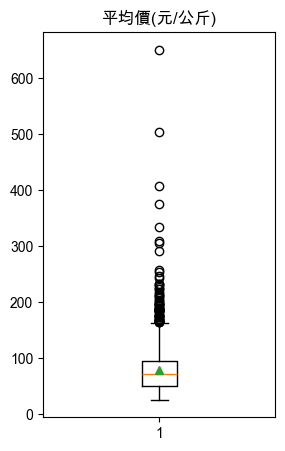

In [17]:
# 設置支持中文的字體(macbook => Arial Unicode MS)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 箱型圖
plt.figure(figsize=(3,5))
plt.boxplot(anal_data['平均價(元/公斤)'],showmeans=True)
plt.title('平均價(元/公斤)')
plt.show()

In [18]:
# skewness and kurtosis
print("偏態(Skewness): {:.2f}".format(anal_data['平均價(元/公斤)'].skew()))
print("峰度(Kurtosis): {:.2f}".format(anal_data['平均價(元/公斤)'].kurt()))

偏態(Skewness): 3.74
峰度(Kurtosis): 32.18


In [19]:
print ("Shape Of The Before Ouliers: ",anal_data.shape)
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(anal_data['平均價(元/公斤)'],75) - np.percentile(anal_data['平均價(元/公斤)'],25)
#outlier = Q3 + n*IQR
outlier=anal_data[anal_data['平均價(元/公斤)'] < np.percentile(anal_data['平均價(元/公斤)'],75)+n*IQR]
#outlier = Q1 - n*IQR
outlier=anal_data[anal_data['平均價(元/公斤)'] > np.percentile(anal_data['平均價(元/公斤)'],25)-n*IQR]
print ("Shape Of The After Ouliers: ",anal_data.shape)

Shape Of The Before Ouliers:  (1830, 1)
Shape Of The After Ouliers:  (1830, 1)


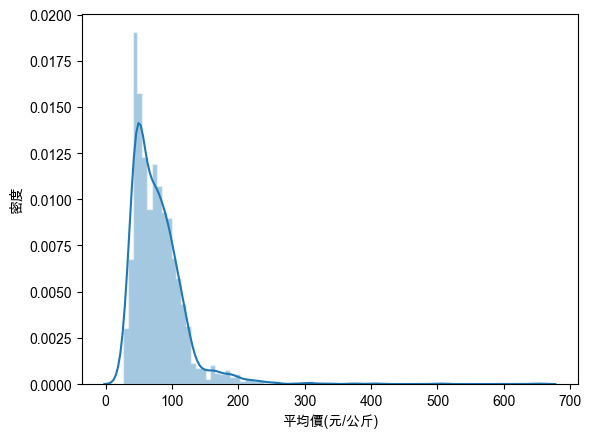

In [20]:
# 常態分布
sns.histplot(anal_data['平均價(元/公斤)'], kde=True, element='step', stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
plt.ylabel('密度')
plt.xlabel('平均價(元/公斤)')
plt.show()

In [21]:
# 設定新的基準日期
# base_date = pd.Timestamp('2014-04-01')
# 將日期轉換為數值型態
df['日期數值'] = (df['日期'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1D')

In [22]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [23]:
import statsmodels.api as sm
X_train = sm.add_constant(train[['日期數值']])
y_train = train['平均價(元/公斤)']
model = sm.OLS(y_train, X_train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              平均價(元/公斤)   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     57.65
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           5.57e-14
Time:                        10:40:02   Log-Likelihood:                -7595.5
No. Observations:                1464   AIC:                         1.519e+04
Df Residuals:                    1462   BIC:                         1.521e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.6877     23.725     10.819      0.0

In [24]:
# 準備測試集特徵
X_test = sm.add_constant(test[['日期數值']])
y_test = test['平均價(元/公斤)']

# 進行預測
y_pred = model.predict(X_test)

# 計算均方誤差（MSE）和均方根誤差（RMSE）
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MSE: 1305.4753817990377
RMSE: 36.13136285554474


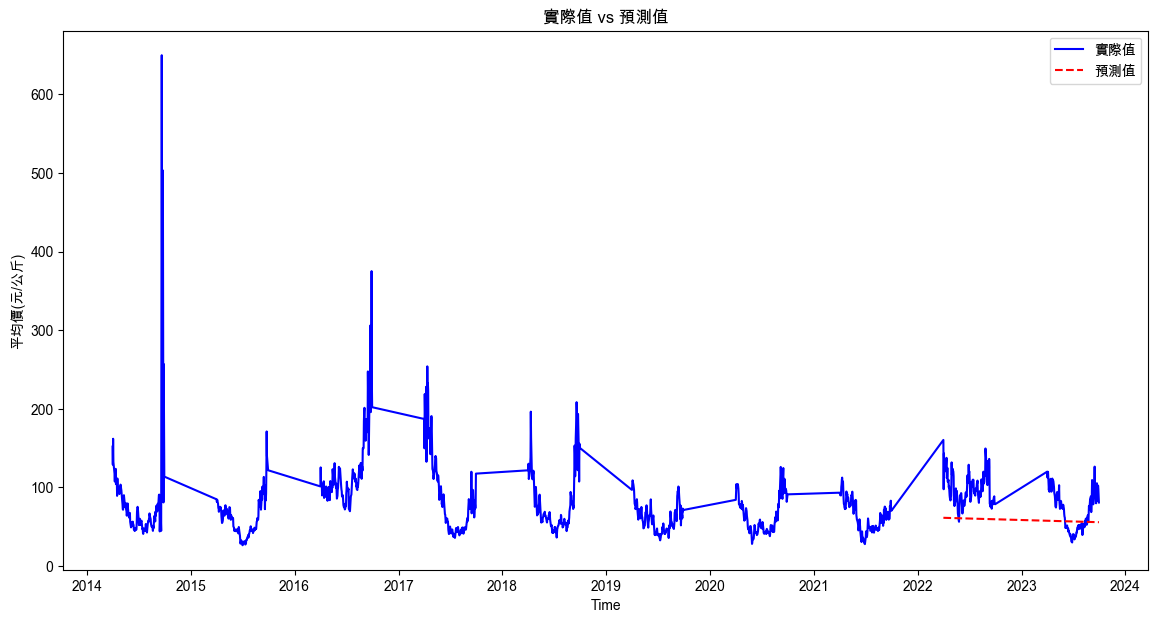

In [25]:
plt.figure(figsize=(14, 7))

# 實際數據
plt.plot(df['日期'], df['平均價(元/公斤)'], label='實際值', color='blue')

# 預測數據
plt.plot(test['日期'], y_pred, label='預測值', color='red', linestyle='--')

plt.xlabel('Time')
plt.ylabel('平均價(元/公斤)')
plt.title('實際值 vs 預測值')
plt.legend()
plt.show()


In [26]:
# 準備進行SARIMA建模的資料
y = df['平均價(元/公斤)']

# 分割資料為訓練集和測試集
train_size = int(len(y) * 0.8)
train, test = y.iloc[:train_size], y.iloc[train_size:]

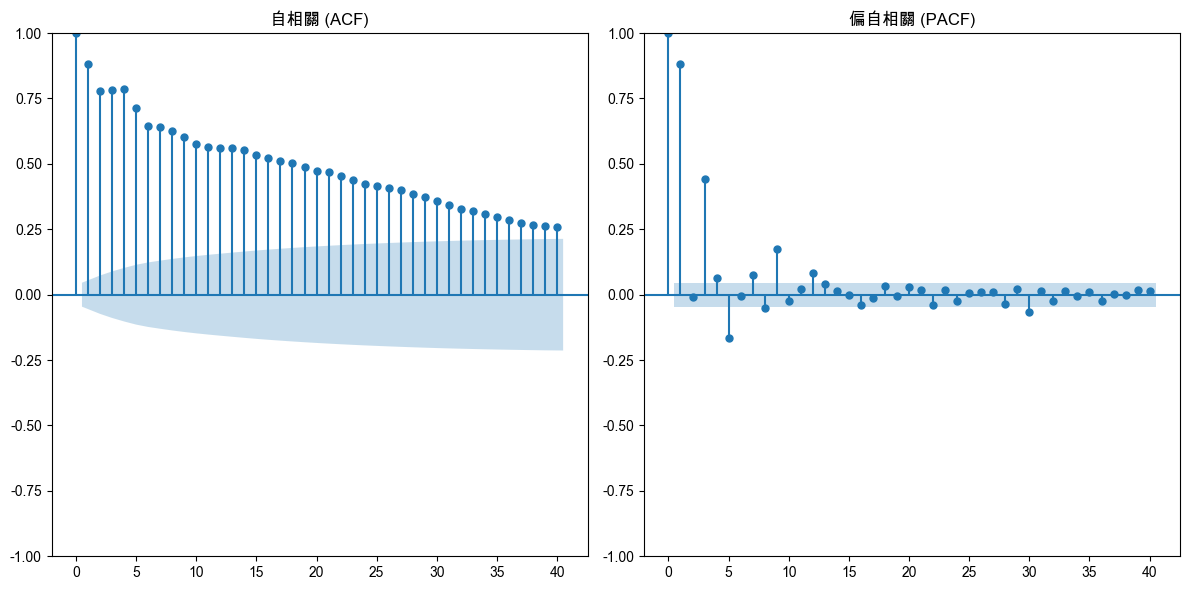

In [27]:
# 自相關圖 (ACF)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(y, ax=plt.gca(), lags=40)
plt.title('自相關 (ACF)')

# 偏自相關圖 (PACF)
plt.subplot(1, 2, 2)
plot_pacf(y, ax=plt.gca(), lags=40)
plt.title('偏自相關 (PACF)')

plt.tight_layout()
plt.show()

In [28]:
# 建立和訓練SARIMA模型
# 注意這裡設置了季節性順序為(1, 1, 1, 6)因為季節性是每年6個月（4到9月）
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 180))
model_fit = model.fit(method='lbfgs', maxiter=200, disp=False)

In [29]:
# 預測
y_pred_train = model_fit.predict(start=train.index[0], end=train.index[-1], dynamic=False)
y_pred_test = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

In [30]:
# 計算評估指標
mse_train = mean_squared_error(train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(train, y_pred_train)

mse_test = mean_squared_error(test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test, y_pred_test)

# 四捨五入到小數點後四位
mse_train_rounded = round(mse_train, 4)
rmse_train_rounded = round(rmse_train, 4)
mae_train_rounded = round(mae_train, 4)

mse_test_rounded = round(mse_test, 4)
rmse_test_rounded = round(rmse_test, 4)
mae_test_rounded = round(mae_test, 4)

print("Training MSE: ", mse_train_rounded)
print("Training RMSE: ", rmse_train_rounded)
print("Training MAE: ", mae_train_rounded)
print("Testing MSE: ", mse_test_rounded)
print("Testing RMSE: ", rmse_test_rounded)
print("Testing MAE: ", mae_test_rounded)


Training MSE:  864.7543
Training RMSE:  29.4067
Training MAE:  10.7963
Testing MSE:  3521.2383
Testing RMSE:  59.34
Testing MAE:  56.0621


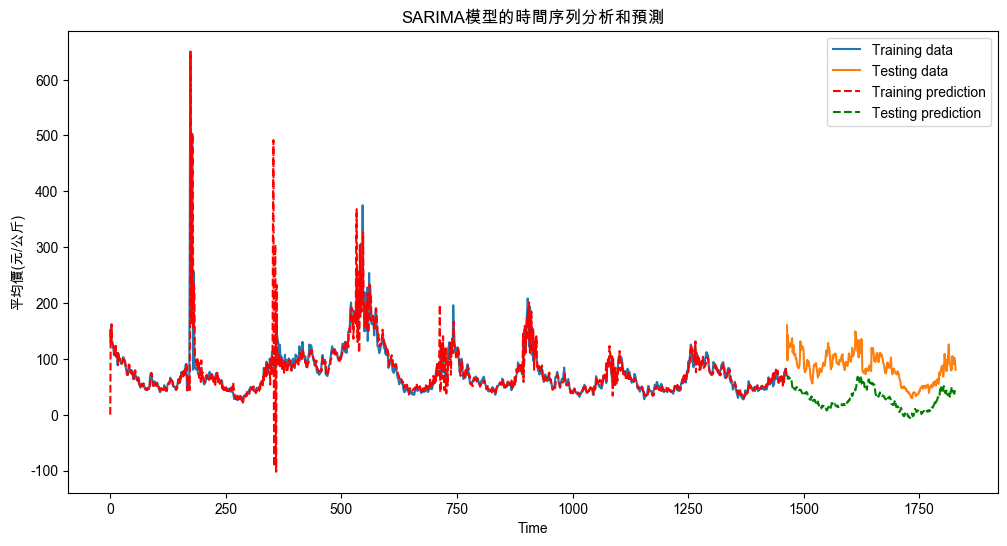

In [31]:
# 視覺化
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training data')
plt.plot(test.index, test, label='Testing data')
plt.plot(train.index, y_pred_train, color='red', linestyle='--', label='Training prediction')
plt.plot(test.index, y_pred_test, color='green', linestyle='--', label='Testing prediction')
plt.xlabel('Time')
plt.ylabel('平均價(元/公斤)')
plt.title('SARIMA模型的時間序列分析和預測')

plt.legend()
plt.show()

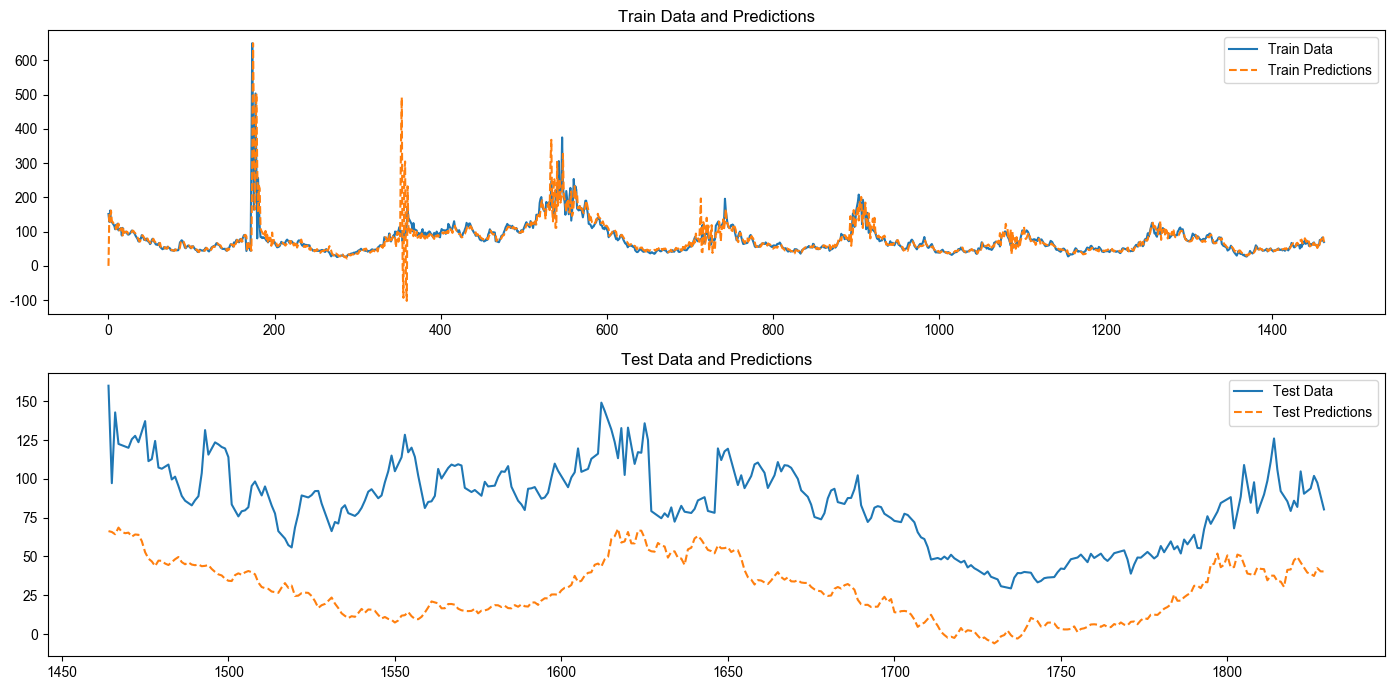

In [32]:
# 繪製結果
plt.figure(figsize=(14, 7))

# 繪製實際數據和訓練預測
plt.subplot(2, 1, 1)
plt.plot(train.index, train, label='Train Data')
plt.plot(train.index, y_pred_train, label='Train Predictions', linestyle='--')
plt.legend()
plt.title('Train Data and Predictions')

# 繪製測試數據和測試預測
plt.subplot(2, 1, 2)
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, y_pred_test, label='Test Predictions', linestyle='--')
plt.legend()
plt.title('Test Data and Predictions')

plt.tight_layout()
plt.show()

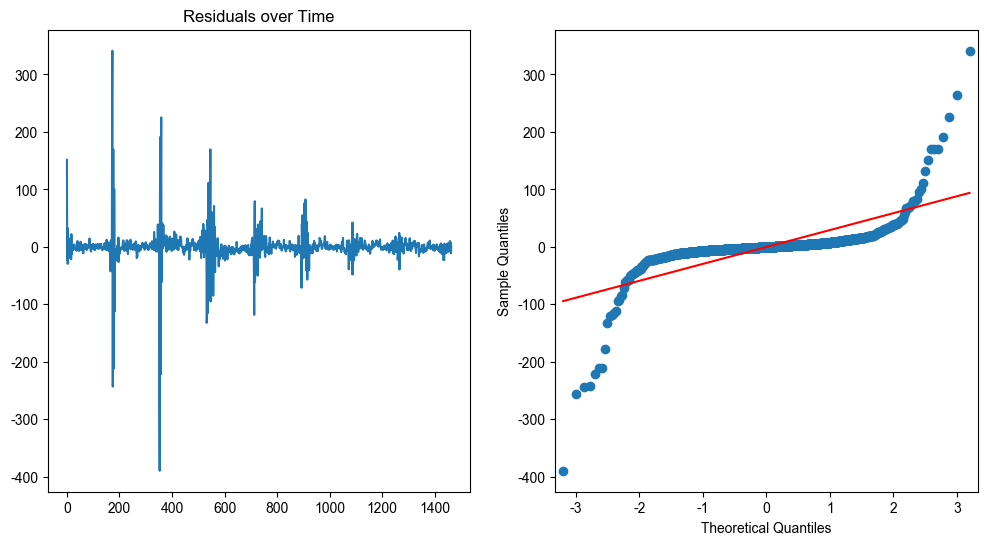

In [33]:
# 計算訓練集的殘差
residuals = train - y_pred_train  

# 殘差隨時間變化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals over Time')

# Q-Q 圖
plt.subplot(1, 2, 2)
qqplot(residuals, line='s', ax=plt.gca())
plt.show()
